# Imports
Most imports needed to run this notebook are listed here. Please make sure they run properly before continuing running other cells.

In [ ]:
# please note that potentially you'll have to restart the runtime and execute this cell a second time for this to work
!git clone https://github.com/huggingface/neuralcoref.git
%cd neuralcoref
!pip install -r requirements.txt
!pip install -e .

Cloning into 'neuralcoref'...
remote: Enumerating objects: 772, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 772 (delta 10), reused 16 (delta 7), pack-reused 748
Receiving objects: 100% (772/772), 67.85 MiB | 17.14 MiB/s, done.
Resolving deltas: 100% (407/407), done.
Checking out files: 100% (151/151), done.
/content/neuralcoref/neuralcoref/neuralcoref
Obtaining file:///content/neuralcoref/neuralcoref/neuralcoref
  Attempting uninstall: neuralcoref
    Found existing installation: neuralcoref 4.0
    Can't uninstall 'neuralcoref'. No files were found to uninstall.
  Running setup.py develop for neuralcoref


In [ ]:
import spacy
import neuralcoref
nlp = spacy.load('en')
neuralcoref.add_to_pipe(nlp)
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import en_core_web_sm
nlp_en_core_web_sm = en_core_web_sm.load()

In [ ]:
!pip install transformers

from transformers import BertModel, BertTokenizer
import torch
from tqdm import tqdm
import torch.nn as nn
import random
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on {}".format(device))

Running on cuda


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pdb
import seaborn as sns
sns.set_theme()
from collections import Counter, OrderedDict
from scipy.stats import norm
import math
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# For this to run, make sure to create a shortcut to the short folder in your personal drive
# Just click on Folder and then "add to drive"
root_path = '/content/drive/My Drive/project_folder'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preparation
Load the train, dev, test files from gdrive. Please note that in order to run the entire out of box error free you are required to authenticate a connection to Google Drive and create a certain file structure. On your personal drive create the following structure:

root_path -> 'INFO 259 - Annotation Project/annotation_project/AP_4/'
- data/70/
    - train.txt
    - dev.txt
    - test.txt
- plots/
- temp/

The following cells will then prepare data to be passed to prediction models by splitting it in features and target values. Categorical labels are replaced with numbers in order to be able to pass it to BERT.

In [ ]:
def load_data(filename):
    ID = []
    XY = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = int(cols[0])
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            ID.append(idd)
            XY.append([text, label])

    return ID, XY

In [ ]:
# load data from gdrive, alternatively change path name and drag and drop files in project
train_ID, train_XY = load_data(root_path + 'data/70/train.txt')
train = pd.DataFrame(train_XY, index=train_ID, columns=['text', 'label'])
dev_ID, dev_XY = load_data(root_path + 'data/70/dev.txt')
dev = pd.DataFrame(dev_XY, index=dev_ID, columns=['text', 'label'])
test_ID, test_XY = load_data(root_path + 'data/70/test.txt')
test = pd.DataFrame(test_XY, index=test_ID, columns=['text', 'label'])

In [ ]:
target = 'label'
feature = 'text'

labels = ['MASTERY', 'INDEPENDENCE', 'STABILITY', 'BELONGING', 'NONE']

train = train.replace(labels, np.arange(0, len(labels)))
dev = dev.replace(labels, np.arange(0, len(labels)))
test = test.replace(labels, np.arange(0, len(labels)))

X_train = list(train[feature].values)
y_train = list(train[target].values)

X_dev = list(dev[feature].values)
y_dev = list(dev[target].values)

X_test = list(test[feature].values)
y_test = list(test[target].values)

print('Training data: ', len(X_train))
print('Evaluation data: ', len(X_dev))
print('Test data: ', len(X_test))

Training data:  600
Evaluation data:  200
Test data:  200


# Installing BERT
We based our BERT implementation on the notebook provided. We added an additional function to make predictions using the trained model.

In [ ]:
def evaluate(model, x, y):
    model.eval()
    corr = 0.
    total = 0.
    with torch.no_grad():
        for x, y in zip(x, y):
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                if prediction == y[idx]:
                    corr += 1.
                total+=1                          
    return corr/total

In [ ]:
def make_predictions(model, X, labels):
    model.eval()
    corr = 0.
    total = 0.

    predictions = []
    with torch.no_grad():
        for x in X:
            y_preds=model.forward(x)
            for idx, y_pred in enumerate(y_preds):
                prediction=torch.argmax(y_pred)
                predictions.append(labels[prediction.item()])                  
    return predictions

In [ ]:
class BERTClassifier(nn.Module):

    
    def __init__(self, params):
        super().__init__()
    
        self.model_name=params["model_name"]
        self.tokenizer = BertTokenizer.from_pretrained(self.model_name, do_lower_case=params["doLowerCase"], do_basic_tokenize=False)
        # self.tokenizer.add_tokens(["[ENTITY]"], special_tokens=True)

        self.bert = BertModel.from_pretrained(self.model_name)
        # self.bert.resize_token_embeddings(len(self.tokenizer))
        
        self.num_labels = params["label_length"]

        self.fc = nn.Linear(params["embedding_size"], self.num_labels)

    def get_batches(self, all_x, all_y, batch_size=32, max_toks=256):
            
        """ Get batches for input x, y data, with data tokenized according to the BERT tokenizer 
      (and limited to a maximum number of WordPiece tokens """

        batches_x=[]
        batches_y=[]
        
        for i in range(0, len(all_x), batch_size):

            current_batch=[]

            x=all_x[i:i+batch_size]

            batch_x = self.tokenizer(x, padding=True, truncation=True, return_tensors="pt", max_length=max_toks)
            batch_y=all_y[i:i+batch_size]

            batches_x.append(batch_x.to(device))
            batches_y.append(torch.LongTensor(batch_y).to(device))
            
        return batches_x, batches_y
  

    def forward(self, batch_x): 
    
        bert_output = self.bert(input_ids=batch_x["input_ids"],
                         attention_mask=batch_x["attention_mask"],
                         token_type_ids=batch_x["token_type_ids"],
                         output_hidden_states=True)

        bert_hidden_states = bert_output['hidden_states']

        # We're going to represent an entire document just by its [CLS] embedding (at position 0)
        out = bert_hidden_states[-1][:,0,:]

        out = self.fc(out)

        return out.squeeze()

In [ ]:
def train_and_evaluate(bert_model_name, model_filename, train_x, train_y, dev_x, dev_y, labels, embedding_size=768, doLowerCase=None):

  start_time=time.time()
  bert_model = BERTClassifier(params={"doLowerCase": doLowerCase, "model_name": bert_model_name, "embedding_size":embedding_size, "label_length": len(labels)})
  bert_model.to(device)

  batch_x, batch_y = bert_model.get_batches(train_x, train_y)
  dev_batch_x, dev_batch_y = bert_model.get_batches(dev_x, dev_y)

  optimizer = torch.optim.Adam(bert_model.parameters(), lr=1e-5)
  cross_entropy=nn.CrossEntropyLoss()

  num_epochs=5
  best_dev_acc = 0.

  for epoch in range(num_epochs):
      bert_model.train()

      # Train
      for x, y in tqdm(list(zip(batch_x, batch_y))):
          y_pred = bert_model.forward(x)
          loss = cross_entropy(y_pred.view(-1, bert_model.num_labels), y.view(-1))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      
      # Evaluate
      dev_accuracy=evaluate(bert_model, dev_batch_x, dev_batch_y)
      if epoch % 1 == 0:
          print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
          if dev_accuracy > best_dev_acc:
              output = open(model_filename, mode="wb")
              torch.save(bert_model.state_dict(), model_filename)
              output.close()
              best_dev_acc = dev_accuracy

  bert_model.load_state_dict(torch.load(model_filename))
  print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))
  print("Time: %.3f seconds ---" % (time.time() - start_time))
  return bert_model

# Running BERT on entire text
We are training a BERT model to predict the categorical archetype label and simply pass the book description as input. BERT will tokenize the description and take the first 256 tokens into account.

In [ ]:
bert_model = train_and_evaluate("bert-base-cased", "bert-trained.pt", X_train, y_train, X_dev, y_dev, labels, embedding_size=768, doLowerCase=False)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 19/19 [00:23<00:00,  1.24s/it]


Epoch 0, dev accuracy: 0.345


100%|██████████| 19/19 [00:23<00:00,  1.26s/it]


Epoch 1, dev accuracy: 0.380


100%|██████████| 19/19 [00:24<00:00,  1.28s/it]


Epoch 2, dev accuracy: 0.445


100%|██████████| 19/19 [00:24<00:00,  1.30s/it]


Epoch 3, dev accuracy: 0.465


100%|██████████| 19/19 [00:25<00:00,  1.32s/it]


Epoch 4, dev accuracy: 0.475

Best Performing Model achieves dev accuracy of : 0.475
Time: 170.176 seconds ---


In [ ]:
test_batch_x, test_batch_y = bert_model.get_batches(X_test, y_test)
yhat_test = make_predictions(bert_model, test_batch_x, labels)

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

Accuracy on test set: 0.505, 95% CIs: [0.436 0.574]


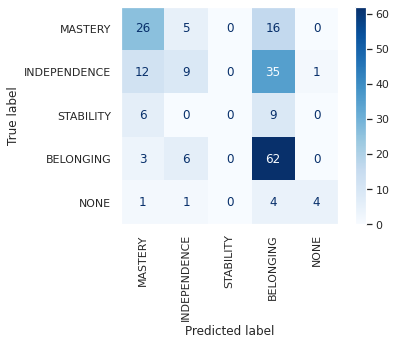

In [ ]:
y_test_labels = [labels[x] for x in y_test]

lower, upper=confidence_intervals(accuracy_score(y_test_labels, yhat_test), len(y_test_labels), .95)
print('Accuracy on test set: %.3f, 95%% CIs: [%.3f %.3f]' % (accuracy_score(y_test_labels, yhat_test), lower, upper))
cm = confusion_matrix(y_test_labels, yhat_test, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.grid(visible=None)
plt.xticks(rotation=90)
plt.savefig(root_path + 'plots/BERT_text_confusion', format='pdf', bbox_inches="tight")
plt.show()

# Correference Resolution
In order to improve the performance we aim to achieve two objectives:
1. Increase the share of information that is character related
2. Pass sentences instead of entire paragraphs, in order to prevent how BERT has to disregard some of the information.

In order to identify the main character we are using the [spaCY](https://spacy.io/) library. We also did this prior to annotating our data and assigned the label in respect to the identified character. Because we did not want to load external pre-computed data, here we are recalculating the main character within this notebook following the same approach. Still it might be that these results differ slightly from the original computed characters.

Using the en_core_web_sm spaCY library we identify all persons. Then we adjudicate mentions of the same character in regards of first and last name. Finally we count how often each character is mentioned and return the most frequently mentioned one. As an additional constraint it has to be mentioned more than three times.

Further, we identify all correference of that identified character. To do so we use the spaCY based Neuralcoref library. We identify all characters in the text (if this sounds redundant, it's because as mentioned earlier we had identified the main character prior to annotation). We search for all correference clusters containing our identified character. We then analyze the correference resolved text and filter it for sentences containing our character. We export the original sentence, the correference resolved and an [ENTITY] sentence. For the [ENTITY] sentence we replace each character mention with this tag. Finally we return all sentences and save them as pandas dataframe.

In [ ]:
def get_main_character(summary):
    nlp_summary = nlp_en_core_web_sm(summary)
    persons = [ent.text for ent in nlp_summary.ents if ent.label_ == 'PERSON']
    
    # unite first and last names
    for idx, person_i in enumerate(persons):
      for person_j in persons:
        if person_i in person_j and len(person_i) < len(person_j):
          persons[idx] = person_j
        
    # get unique names
    persons = set(persons)
    
    def split_name(full_name):
        parts = full_name.split(" ")
        first_name = parts[0]
        last_name = "" if len(parts) < 2 else parts[1]
        return first_name, last_name
    
    def countOccurrences(summary, full_name):
        first_name, last_name = split_name(full_name)
        
        first_name_count = summary.count(first_name) if first_name != "" else 0
        last_name_count = summary.count(last_name) if last_name != "" else 0
        full_name_count = summary.count(full_name) if full_name != "" and last_name != "" and first_name != ""  else 0
        return first_name_count + last_name_count - full_name_count
        
    counter = {}
    for idx, person in enumerate(persons):
        occurences = countOccurrences(summary, person)
        counter[person] = occurences
    
    first_name, last_name, count = "", "", 0
    if len(counter) > 0:
        best_guess = max(counter, key= lambda x: counter[x])
        count = counter[best_guess]
        first_name, last_name = split_name(best_guess)
    
    min_count = 3
    if count >= min_count:
            return first_name, last_name
        
    return "", ""

In [ ]:
def get_correferences_count(clusters, first_name, last_name):
    
    full_name = first_name + " " + last_name
    
    mentions = []
    mains = []
    
    # filter clusters for mentioning of character
    for cluster in clusters:
        if full_name in str(cluster.mentions) \
        or first_name in str(cluster.mentions) \
        or first_name == "" and last_name in str(cluster.mentions):
            mentions.append(cluster.mentions)
            mains.append(cluster.main)
    
    mentions = [str(item) for sublist in mentions for item in sublist]
    mains = [str(item) for item in mains]
    
    return dict(Counter(mentions)), mains

def get_correferences_sentences(summary, summary_new, correference_count, mains, first_name, last_name):
    
    old_sentences = nltk.tokenize.sent_tokenize(summary)
    new_sentences = nltk.tokenize.sent_tokenize(summary_new)
    
    # add first name and last name, if no mentioning of character was detected
    if len(mains) == 0:
        if first_name != "": mains.append(first_name)
        if last_name != "": mains.append(last_name)
    
    # extract original sentences where character or its correference is mentioned
    correference_sentences = []
    for idx, sentence in enumerate(new_sentences):
        if idx < len(old_sentences):
            entity_sentence = sentence
            
            # correferences = []
            included = False
            for main in mains:
                if main in sentence:
                    included = True
                    entity_sentence = entity_sentence.replace(main, '[ENTITY]')

            if included:
                correference_sentences.append((entity_sentence, old_sentences[idx], new_sentences[idx]))

    return correference_sentences

def get_entity_text(summary_new, mains, first_name, last_name):
    entity_text = summary_new
    for main in mains:
        entity_text = entity_text.replace(main, '[ENTITY]')
        
    if first_name != "":
        entity_text = entity_text.replace(first_name, '[ENTITY]')
    if last_name != "":
        entity_text = entity_text.replace(last_name, '[ENTITY]')
    
    return entity_text
    

def get_correferences(summary, first_name, last_name):
    doc = nlp(summary)
    clusters = doc._.coref_clusters
    
    correference_count, mains = get_correferences_count(clusters, first_name, last_name)
    correference_sentences = get_correferences_sentences(summary,  doc._.coref_resolved, correference_count, mains, first_name, last_name)
    entity_text = get_entity_text(doc._.coref_resolved, mains, first_name, last_name)

    return correference_count, entity_text, doc._.coref_resolved, correference_sentences

In [ ]:
data = pd.concat([train, dev, test])

df_correference_sentences = pd.DataFrame() # id | book_id, entity_sentence, original_sentence, replaced_sentence
df_correference_text = pd.DataFrame() # id | book_id, entity_text, original_text, replaced_text

n = data.shape[0]

for book_id, book in tqdm(data.head(n).iterrows(), total=n):
    first_name, last_name = get_main_character(book['text'])
    correference_count, entity_text, correference_text, correference_sentences = get_correferences(book['text'], first_name, last_name)

    df_text = pd.DataFrame([[book_id, first_name, last_name, entity_text, book['text'], correference_text]], columns=['book_id', 'first_name', 'last_name', 'entity_text', 'original_text', 'replaced_text'])
    df_correference_text = pd.concat([df_correference_text, df_text], ignore_index=True)
    
    df_sentences = pd.DataFrame(correference_sentences, columns=['entity_sentence', 'original_sentence', 'replaced_sentence'])
    df_sentences = df_sentences.assign(book_id=book_id)
    df_sentences = df_sentences.assign(first_name=first_name)
    df_sentences = df_sentences.assign(last_name=last_name)

    # to ensure that book 13483233 is included
    if df_sentences.shape[0] == 0:
      df_sentences = pd.DataFrame([[first_name, last_name, "", "", ""]], columns=['first_name', 'last_name', 'entity_sentence', 'original_sentence', 'replaced_sentence'])
      df_sentences = df_sentences.assign(book_id=book_id)

    df_correference_sentences = pd.concat([df_correference_sentences, df_sentences], ignore_index=True)

# reorder columns
df_correference_sentences = df_correference_sentences[['book_id', 'first_name', 'last_name', 'entity_sentence', 'original_sentence', 'replaced_sentence']]

display(df_correference_text.head())
display(df_correference_sentences.head())

100%|██████████| 1000/1000 [03:18<00:00,  5.04it/s]


,book_id,first_name,last_name,entity_text,original_text,replaced_text
0,34727935,le,manuel,Quand [ENTITY] magizoologiste Norbert Dragonne...,Quand le magizoologiste Norbert Dragonneau arr...,Quand le magizoologiste Norbert Dragonneau arr...
1,13343514,Lucy,Desberg,[ENTITY] is a natural problem solver. After th...,Twelve-year-old Lucy Desberg is a natural prob...,Twelve-year-old Lucy Desberg is a natural prob...
2,10990017,Lucy,,"Every winter, straight-laced, Ivy League bound...","Every winter, straight-laced, Ivy League bound...","Every winter, straight-laced, Ivy League bound..."
3,358187,Darcy,,It is 1974 and the country is still struggling...,It is 1974 and the country is still struggling...,It is 1974 and the country is still struggling...
4,28256471,Lara,,[ENTITY] just got told off on Facebook.[ENTITY...,Lara just got told off on Facebook.She thought...,Lara just got told off on Facebook.Lara though...


,book_id,first_name,last_name,entity_sentence,original_sentence,replaced_sentence
0,34727935,le,manuel,Quand [ENTITY] magizoologiste Norbert Dragonne...,Quand le magizoologiste Norbert Dragonneau arr...,Quand le magizoologiste Norbert Dragonneau arr...
1,34727935,le,manuel,Mais sa valise magique est egaree et certains ...,Mais sa valise magique est egaree et certains ...,Mais sa valise magique est egaree et certains ...
2,34727935,le,manuel,Les ennuis commencent alors... pour tout [ENTI...,Les ennuis commencent alors... pour tout le mo...,Les ennuis commencent alors... pour tout le mo...
3,34727935,le,manuel,Eclatante d'imagination et racontee de main de...,Eclatante d'imagination et racontee de main de...,Eclatante d'imagination et racontee de main de...
4,34727935,le,manuel,"Que l'on soit deja fan, ou nouveau dans [ENTIT...","Que l'on soit deja fan, ou nouveau dans le Mon...","Que l'on soit deja fan, ou nouveau dans le Mon..."


In [ ]:
# save results to gdrive to allow reloading it if necesseary
df_correference_text.to_csv(root_path + 'temp/df_correference_text.csv')
df_correference_sentences.to_csv(root_path + 'temp/df_correference_sentences.csv')

In [ ]:
# load results from gdrive instead of computing them again
df_correference_text = pd.read_csv(root_path + 'temp/df_correference_text.csv', index_col=0).fillna('')
df_correference_sentences = pd.read_csv(root_path + 'temp/df_correference_sentences.csv', index_col=0).fillna('')

# Run BERT model on character sentences 
To train our model on sentences rather than the entire text, we use the above created sentence dataset. We split the dataset in train, dev and test according to their book_id (using the split provided). We first evaluate the model's sentence-based accuracy. Then, we adjudicate the labels for each book by majority vote and evaluate the accuracy again.



In [ ]:
target = 'label'
feature = 'original_sentence'

train_sentences = df_correference_sentences[df_correference_sentences['book_id'].isin(train_ID)].merge(train['label'], left_on='book_id', right_index=True)
dev_sentences = df_correference_sentences[df_correference_sentences['book_id'].isin(dev_ID)].merge(dev['label'], left_on='book_id', right_index=True)
test_sentences = df_correference_sentences[df_correference_sentences['book_id'].isin(test_ID)].merge(test['label'], left_on='book_id', right_index=True)

train_text = df_correference_text[df_correference_text['book_id'].isin(train_ID)].merge(train['label'], left_on='book_id', right_index=True)
dev_text = df_correference_text[df_correference_text['book_id'].isin(dev_ID)].merge(dev['label'], left_on='book_id', right_index=True)
test_text = df_correference_text[df_correference_text['book_id'].isin(test_ID)].merge(test['label'], left_on='book_id', right_index=True)

X_train = list(train_sentences[feature].values)
y_train = list(train_sentences[target].values)

X_dev = list(dev_sentences[feature].values)
y_dev = list(dev_sentences[target].values)

X_test = list(test_sentences[feature].values)
y_test = list(test_sentences[target].values)

print('Training data: ', len(X_train))
print('Evaluation data: ', len(X_dev))
print('Test data: ', len(X_test))

Training data:  2917
Evaluation data:  970
Test data:  990


In [ ]:
bert_model = train_and_evaluate("bert-base-cased", "bert-trained.pt", X_train, y_train, X_dev, y_dev, labels, embedding_size=768, doLowerCase=False)
test_batch_x, test_batch_y = bert_model.get_batches(X_test, y_test)
yhat_test = make_predictions(bert_model, test_batch_x, labels)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 92/92 [00:48<00:00,  1.90it/s]


Epoch 0, dev accuracy: 0.368


100%|██████████| 92/92 [00:51<00:00,  1.79it/s]


Epoch 1, dev accuracy: 0.489


100%|██████████| 92/92 [00:51<00:00,  1.77it/s]


Epoch 2, dev accuracy: 0.504


100%|██████████| 92/92 [00:51<00:00,  1.78it/s]


Epoch 3, dev accuracy: 0.502


100%|██████████| 92/92 [00:51<00:00,  1.78it/s]


Epoch 4, dev accuracy: 0.501

Best Performing Model achieves dev accuracy of : 0.504
Time: 301.709 seconds ---


Accuracy on test set: 0.491, 95% CIs: [0.460 0.522]


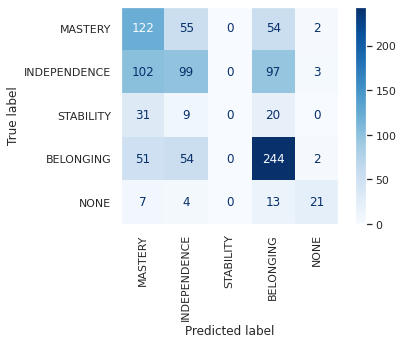

In [ ]:
y_test_labels = [labels[x] for x in y_test]

lower, upper=confidence_intervals(accuracy_score(y_test_labels, yhat_test), len(y_test_labels), .95)
print('Accuracy on test set: %.3f, 95%% CIs: [%.3f %.3f]' % (accuracy_score(y_test_labels, yhat_test), lower, upper))
cm = confusion_matrix(y_test_labels, yhat_test, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.grid(visible=None)
plt.xticks(rotation=90)
plt.savefig(root_path + 'plots/BERT_sentence_confusion', format='pdf', bbox_inches="tight")
plt.show()

Baseline - majority-class on test set: 0.355
Accuracy on test set - adjudicated: 0.550, 95% CIs: [0.481 0.619]


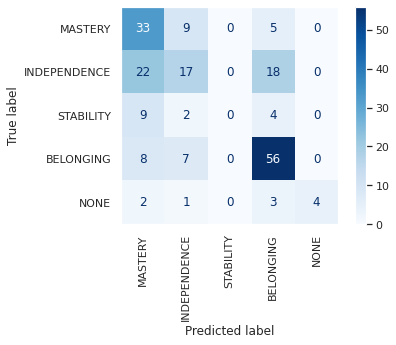

In [ ]:
# Transform multiple labels (eg. Sentence or reviews) in adjudicated label

import collections

prediction_dict = collections.defaultdict(list)
book_ids = test_sentences.book_id.values

for i, prediction in enumerate(yhat_test):
  prediction_dict[book_ids[i]].append(prediction)

for k, v in prediction_dict.items():
  prediction_dict[k] = Counter(v).most_common(1)[0][0]

book_predictions = list(prediction_dict.values())
book_label = test.copy()
book_label[target] = [labels[x] for x in test[target]]

predictions_df = pd.DataFrame(book_predictions, columns=['prediction'], index=prediction_dict.keys())
predictions_df = predictions_df.merge(book_label[target], left_index=True, right_index=True)

majority_class = [Counter(predictions_df[target]).most_common(1)[0][0]] * len(predictions_df[target])
print('Baseline - majority-class on test set: %.3f' % accuracy_score(predictions_df[target], majority_class))

lower, upper=confidence_intervals(accuracy_score(predictions_df[target], predictions_df['prediction']), len(predictions_df[target]), .95)
print('Accuracy on test set - adjudicated: %.3f, 95%% CIs: [%.3f %.3f]' % (accuracy_score(predictions_df[target], predictions_df['prediction']), lower, upper))
cm = confusion_matrix(predictions_df[target], predictions_df['prediction'], labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.grid(visible=None)
plt.xticks(rotation=90)
plt.savefig(root_path + 'plots/BERT_sentence_adjudicated_confusion', format='pdf', bbox_inches="tight")
plt.show()

# Detailed analysis BERT sentence Model

In [ ]:
export = test_sentences[['book_id', 'first_name', 'last_name', 'original_sentence', 'label']].copy()
export['label'] = y_test_labels
export['prediction'] = yhat_test
export.to_csv(root_path + 'temp/bert_sentence_prediction.csv')
export

,book_id,first_name,last_name,original_sentence,label,prediction
3887,2800405,Jack,Perdu,"Jack Perdu, a shy, ninth grade classics prodig...",INDEPENDENCE,BELONGING
3888,2800405,Jack,Perdu,"Smart and introverted, Jack spends most of his...",INDEPENDENCE,BELONGING
3889,2800405,Jack,Perdu,"But when Jack suffers a near fatal accident, h...",INDEPENDENCE,BELONGING
3890,2800405,Jack,Perdu,His father sends him to a mysterious doctor in...,INDEPENDENCE,INDEPENDENCE
3891,2800405,Jack,Perdu,"While in the city, Jack meets Euri, a young gi...",INDEPENDENCE,INDEPENDENCE
...,...,...,...,...,...,...
4872,8706231,Fever,Crumb,"Soon though, she must say goodbye to Dr. Crumb...",INDEPENDENCE,MASTERY
4873,8706231,Fever,Crumb,"As her work begins, Fever is plagued by memori...",INDEPENDENCE,MASTERY
4874,8706231,Fever,Crumb,"The Scriveners, not human, ruled the city some...",INDEPENDENCE,MASTERY
4875,8706231,Fever,Crumb,Is Fever a Scriven?,INDEPENDENCE,BELONGING


In [ ]:
export = test_text[['book_id', 'first_name', 'last_name', 'original_text', 'label']].merge(predictions_df['prediction'], left_on='book_id', right_index=True)
export['label'] = [labels[x] for x in export['label']]
export.to_csv(root_path + 'temp/bert_adjudicated_prediction.csv')
export

,book_id,first_name,last_name,original_text,label,prediction
800,2800405,Jack,Perdu,"Jack Perdu, a shy, ninth grade classics prodig...",INDEPENDENCE,BELONGING
801,20894021,Emily,Bird,Emily Bird was raised not to ask questions. Sh...,MASTERY,MASTERY
802,28113823,Joe,St,Missing Dad - Wanted is the first in a new ser...,INDEPENDENCE,MASTERY
803,8430147,Rosie,March,Scarlett March lives to hunt the Fenris--the w...,BELONGING,MASTERY
804,17689281,Saylor,Grayson,Saylor Grayson makes herself sick. Literally.S...,BELONGING,BELONGING
...,...,...,...,...,...,...
995,2964700,Beka,Cooper,The Hunt is on!Three years have passed since B...,MASTERY,MASTERY
996,1865670,Shrimp,,"If Cyd Charisse knows one thing, it's that Shr...",BELONGING,BELONGING
997,32622042,Nyssa,Glass,Reformed cat burglar Nyssa Glass fled her home...,MASTERY,INDEPENDENCE
998,25986903,Rashad,,In an unforgettable new novel from award-winni...,INDEPENDENCE,INDEPENDENCE


### Observations and Insights
For an overall evaluation of performance, please refer to the summary section below. In this section we want to highlight some interesting findings we were able to generate by analysing the confusion matrix of the model (see above) and deep diving into some of the misspredicted labels.

**Failure to predict Stability-labeled entries correctly** <br/>
Our BERT model was unable to predict *Stability* on our adjudicated data, both on the text-level and on the sentence level. From a computational perspective, this can perhaps be explained by pointing out that there were not a lot of examples of *Stability* archetypes in our training data in the first place, and therefore less runway for our model to learn this association. This is indeed true. Out of all 600 entries in our training set, only 24 of them were labeled with *Stability* (just 4% of the training data). For context, 75 (12.5%) were labeled with *Mastery*, 78 (13%) with *Independence*, and 80 (13.3%) with *Belonging*. These proportions are also true to our total annotated dataset.
To fix this in the future, we would probably assign the *Stability* label a bit more weight so that there is less disproportionality among the labels. We know that this would likely work because *Belonging*, which was our majority class, was the most represented among our predictions.

There are a few reasons that could lead to the low accuracy of the NLP models.

First, for characters with multiple archetypes, we provide the annotation guideline that the archetype that is more prominent or that matches the theme of the story. The adjudicated BERT model identifies the type for the character based on the number of sentences that are assigned that type. However, some sentences, usually longer sentences, are more informative about the character's type or the theme of the book. If all sentences are given the same weight, the results from the BERT adjudicated models would probably differ from the human annotation results, especially when the book summary contains a lot of short sentences that provide mostly background information. Thus, accuracy might be improved if we assign different weights to the sentences based on their informativeness and the usual way to do that is based on the length of the sentence. 

One example for this is for Book ID#2800405: 
<br/>“[1]Jack Perdu, a shy, ninth grade classics prodigy lives with father on the Yale University campus. <br/>[2] Smart and introverted, Jack spends most of his time alone, his nose buried in a book. <br/>[3] But when Jack suffers a near fatal accident, his life is forever changed. <br>[4] His father sends him to a mysterious doctor in New York City--a place Jack hasn't been since his mother died there eight years ago. <br/>[5]While in the city, Jack meets Euri, a young girl who offers to show him the secrets of Grand Central Station. <br/>[6]Here, Jack discovers New York's Underworld, a place where those who died in the city reside until they are ready to move on. <br/>[7]This, Jack believes, is a chance to see his mother again. <br/>[8]But as secrets about Euri's past are revealed, so are the true reasons for Jack's visit to the Underworld. Masterfully told, The Night Tourist weaves together New York City's secret history and its modern-day landscape to create a highly vivid ghost world, full of magical adventure and page-turning action.”

<br/>The BERT-adjudicated model assigns the Belonging type to sentences [1], [2], [3] and [7], Independence type to sentences [4], [5] and [6] and Mastery type to sentence [8] so the type assigned to the text is Belonging while the label for this text is Independence. But as we can see from the text, sentences [4], [5] and [6] are more informative than sentences [1], [2], [3] and [7] regarding the nature of the character and the theme of the book. This illustrates the shortcoming of the BERT adjudicated model which simply counts the number of sentences for different types and selects the one with the most sentences. 

Second, the differences among different character types might be too subtle to be picked up by the NLP models. As is shown in the Confusion Matrix, the Independence type has the lowest accuracy rate compared to the other types and it's often mistaken for the Mastery type or Belonging type. The main reason for that is the character with multiple archetypes issue we specified in the annotation guidelines, particularly among explorer (Independence type), hero (Mastery type) and everyman (Belonging type). The differences among these archetypes are very subtle and might be harder to be grasped by the machines compared with humans. 

One example for this is for Book ID#2118745:
<br/>“Prentisstown isn't like other towns. Everyone can hear everyone else's thoughts in an overwhelming, never-ending stream of Noise. <br/>[1]Just a month away from the birthday that will make him a man, Todd and his dog, Manchee -- whose thoughts Todd can hear too, whether he wants to or not -- stumble upon an area of complete silence. <br/>[2]They find that in a town where privacy is impossible, something terrible has been hidden -- a secret so awful that Todd and Manchee must run for their lives.But how do you escape when your pursuers can hear your every thought?”

The BERT-adjudicated model assigns the Independence type to both sentences here while the label is Mastery type. We assign the archetype of Hero (Mastery type) to Todd because we think what he experienced resembles a hero’s journey in which he stepped up to solve a posited problem instead of seeking out those problems for himself because of an innate curiosity. This illustrates the subtle difference which is hard to be grasped by the NLP model.


# Installing GloVe and apply to data
We wanted to try a different class of model and decided to run a logistic classifier on GloVe embeddings. We import the GloVe dictionary (containing 100 dimensional vectors) as we did in an earlier assignment. We also wrote a function to compute the average GloVe embedding of a sentence or text.

In [ ]:
!wget https://people.ischool.berkeley.edu/~dbamman/glove.6B.100d.100K.txt
def read_vectors(filename: str):
    vocab_map={}
    embeddings=[]
    with(open(filename, encoding="utf-8")) as file:
        for idx, line in enumerate(file):
            cols=line.rstrip().split(" ")
            word=cols[0]
            embedding=cols[1:]

            embeddings.append(embedding)
            vocab_map[word]=idx
    
    return vocab_map, np.array(embeddings, dtype="float")
glove_vocab_map, glove_embeddings=read_vectors("glove.6B.100d.100K.txt")

--2022-04-21 23:15:27--  https://people.ischool.berkeley.edu/~dbamman/glove.6B.100d.100K.txt
Resolving people.ischool.berkeley.edu (people.ischool.berkeley.edu)... 128.32.78.16
Connecting to people.ischool.berkeley.edu (people.ischool.berkeley.edu)|128.32.78.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85951834 (82M) [text/plain]
Saving to: ‘glove.6B.100d.100K.txt’

glove.6B.100d.100K. 100%[===================>]  81.97M   119MB/s    in 0.7s    

2022-04-21 23:15:28 (119 MB/s) - ‘glove.6B.100d.100K.txt’ saved [85951834/85951834]



In [ ]:
from nltk.tokenize import word_tokenize

def compute_average_GloVe(text):
    words = word_tokenize(text)
    
    embeddings = []
    for i, word in enumerate(words):
      word=word.lower()
      if word in glove_vocab_map:
        idx = glove_vocab_map[word]
        embedding = glove_embeddings[idx]
        embeddings.append(embedding)

    # check if array is empty
    if len(embeddings) == 0:
      # print("Apparently GloVe isn't extensive enough")
      return np.zeros_like(glove_embeddings[0])

    # compute avgerage GloVe vector
    avg_embedding = np.mean(embeddings, axis=0)
    return avg_embedding

# Logistic Regression on entire text
To run a logistic regression on the entire text we transform the text into a 100 dimensional GloVe embedding, by averaging over the individual word vectors. We then explode that vector and train a logistic regression on these 100 features. We use the development data to tune the regularization parameter C. 

In [ ]:
train['text_feature'] = [compute_average_GloVe(text) for text in train['text'].values]
dev['text_feature'] = [compute_average_GloVe(text) for text in dev['text'].values]
test['text_feature'] = [compute_average_GloVe(text) for text in test['text'].values]

def explode_features(data, features):

  n = len(data[features[0]].values[0])
  data_exploded = pd.DataFrame(data[features[0]].tolist(), columns=np.arange(0, n))
  
  if len(features) > 1:
    for idx, feature in enumerate(features[1:]):
      new_data = pd.DataFrame(data[feature].tolist(), columns=np.arange(n * (idx +1), n * (idx +2)))
      data_exploded = data_exploded.merge(new_data, left_index=True, right_index=True)
  
  return data_exploded

features = ['text_feature']
target = 'label'

X_train = explode_features(train, features)
y_train = train[target]

X_dev = explode_features(dev, features)
y_dev = dev[target]

X_test = explode_features(test, features)
y_test = test[target]

print('Training data: ', len(X_train))
print('Evaluation data: ', len(X_dev))
print('Test data: ', len(X_test))

Training data:  600
Evaluation data:  200
Test data:  200


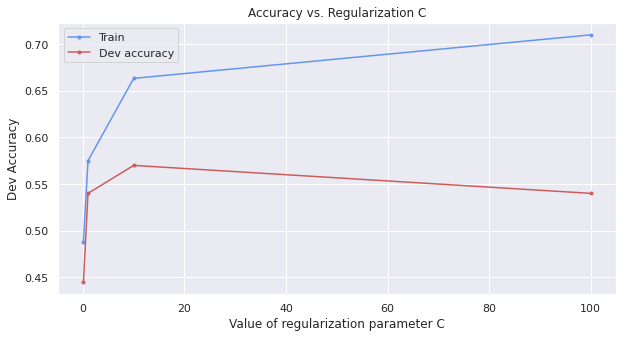

Best C: 10.000
Dev accuracy: 0.570
Accuracy on training set: 0.663
Accuracy on test set: 0.515, 95% CIs: [0.446 0.584]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

model = LogisticRegression(random_state=0, max_iter=10000) 

C_array = [0.1, 1, 10, 100]

dev_accuracies = []
train_accuracies = []

for C in C_array:
  cv_model = LogisticRegression(random_state=0, max_iter=1000, C=C) 
  cv_model.fit(X_train, y_train)
  yhat_train = cv_model.predict(X_train)
  yhat_dev = cv_model.predict(X_dev)
  accuracy_train = accuracy_score(y_train, yhat_train)
  accuracy_dev = accuracy_score(y_dev, yhat_dev)

  if len(dev_accuracies) > 0 and accuracy_dev > np.max(dev_accuracies):
    model = cv_model

  dev_accuracies.append(accuracy_dev)
  train_accuracies.append(accuracy_train)

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(C_array, train_accuracies, label='Train', color="cornflowerblue", marker='.')
ax.plot(C_array, dev_accuracies, label='Dev accuracy', color="indianred", marker='.')
ax.set_xlabel('Value of regularization parameter C')
ax.set_ylabel('Dev Accuracy')
ax.set_title('Accuracy vs. Regularization C')
ax.legend(loc='best')
plt.savefig(root_path + 'plots/LOGISTIC_text_dev', format='pdf', bbox_inches="tight")
plt.show()

# Get predictions on test set using best model
model.fit(X_train, y_train)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

lower, upper=confidence_intervals(accuracy_score(y_test, yhat_test), len(y_test), .95)

print('Best C: %.3f' % C_array[np.argmax(dev_accuracies)])
print('Dev accuracy: %.3f' % np.max(dev_accuracies))
print('Accuracy on training set: %.3f' % accuracy_score(y_train, yhat_train))
print('Accuracy on test set: %.3f, 95%% CIs: [%.3f %.3f]' % (accuracy_score(y_test, yhat_test), lower, upper))

Accuracy on test set: 0.515, 95% CIs: [0.446 0.584]


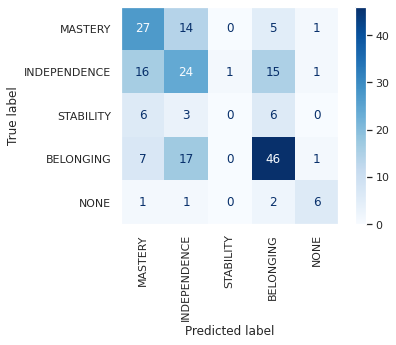

In [ ]:
y_test = [labels[x] for x in y_test]
yhat_test = [labels[x] for x in yhat_test]

print('Accuracy on test set: %.3f, 95%% CIs: [%.3f %.3f]' % (accuracy_score(y_test, yhat_test), lower, upper))
cm = confusion_matrix(y_test, yhat_test, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.grid(visible=None)
plt.xticks(rotation=90)
plt.savefig(root_path + 'plots/LOGISTIC_text_confusion', format='pdf', bbox_inches="tight")
plt.show()

# Logistic Regression on sentences
We then also ran a logistic regression on the individual sentences like we did for BERT. We compute the average GloVe embedding for each sentence, predict the label, and then adjudicate the labels to get a single prediction for each book. Again, we use the development data to tune the regularization parameter C. 

In [ ]:
train_sentences['sentence_feature'] = [compute_average_GloVe(sentence) for sentence in train_sentences['original_sentence'].values]
dev_sentences['sentence_feature'] = [compute_average_GloVe(sentence) for sentence in dev_sentences['original_sentence'].values]
test_sentences['sentence_feature'] = [compute_average_GloVe(sentence) for sentence in test_sentences['original_sentence'].values]

features = ['sentence_feature']
target = 'label'

X_train = explode_features(train_sentences, features)
y_train = train_sentences[target]

X_dev = explode_features(dev_sentences, features)
y_dev = dev_sentences[target]

X_test = explode_features(test_sentences, features)
y_test = test_sentences[target]

print('Training data: ', len(X_train))
print('Evaluation data: ', len(X_dev))
print('Test data: ', len(X_test))

Training data:  2917
Evaluation data:  970
Test data:  990


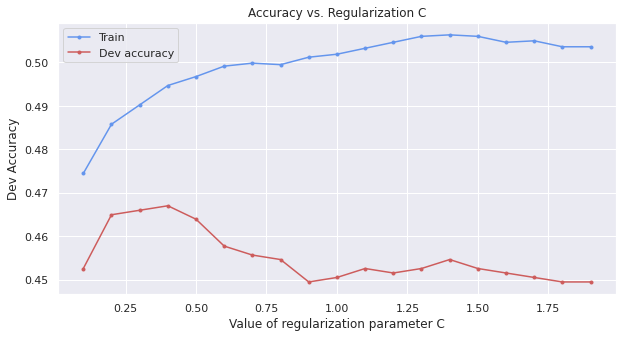

Best C: 0.400
Dev accuracy: 0.467
Accuracy on training set: 0.495
Accuracy on test set: 0.451, 95% CIs: [0.420 0.481]


In [ ]:
model = LogisticRegression(random_state=0, max_iter=10000) 

C_array = np.arange(0.1,2, 0.1)

dev_accuracies = []
train_accuracies = []

for C in C_array:
  cv_model = LogisticRegression(random_state=0, max_iter=1000, C=C) 
  cv_model.fit(X_train, y_train)
  yhat_train = cv_model.predict(X_train)
  yhat_dev = cv_model.predict(X_dev)
  accuracy_train = accuracy_score(y_train, yhat_train)
  accuracy_dev = accuracy_score(y_dev, yhat_dev)

  if len(dev_accuracies) > 0 and accuracy_dev > np.max(dev_accuracies):
    model = cv_model

  dev_accuracies.append(accuracy_dev)
  train_accuracies.append(accuracy_train)

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(C_array, train_accuracies, label='Train', color="cornflowerblue", marker='.')
ax.plot(C_array, dev_accuracies, label='Dev accuracy', color="indianred", marker='.')
ax.set_xlabel('Value of regularization parameter C')
ax.set_ylabel('Dev Accuracy')
ax.set_title('Accuracy vs. Regularization C')
ax.legend(loc='best')
plt.savefig(root_path + 'plots/LOGISTIC_sentence_dev', format='pdf', bbox_inches="tight")
plt.show()

# Get predictions on test set using best model
model.fit(X_train, y_train)
yhat_train = model.predict(X_train)
yhat_test = model.predict(X_test)

lower, upper=confidence_intervals(accuracy_score(y_test, yhat_test), len(y_test), .95)

print('Best C: %.3f' % C_array[np.argmax(dev_accuracies)])
print('Dev accuracy: %.3f' % np.max(dev_accuracies))
print('Accuracy on training set: %.3f' % accuracy_score(y_train, yhat_train))
print('Accuracy on test set: %.3f, 95%% CIs: [%.3f %.3f]' % (accuracy_score(y_test, yhat_test), lower, upper))

Accuracy on test set: 0.451, 95% CIs: [0.420 0.481]


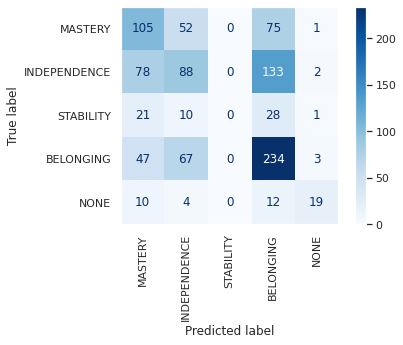

In [ ]:
y_test = [labels[x] for x in y_test]
yhat_test = [labels[x] for x in yhat_test]

print('Accuracy on test set: %.3f, 95%% CIs: [%.3f %.3f]' % (accuracy_score(y_test, yhat_test), lower, upper))
cm = confusion_matrix(y_test, yhat_test, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.grid(visible=None)
plt.xticks(rotation=90)
plt.savefig(root_path + 'plots/LOGISTIC_sentence_confusion', format='pdf', bbox_inches="tight")
plt.show()

Baseline - majority-class on test set: 0.355
Accuracy on test set - adjudicated: 0.465, 95% CIs: [0.396 0.534]


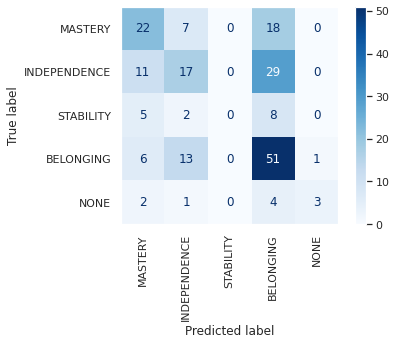

In [ ]:
# Transform multiple labels (eg. Sentence or reviews) in adjudicated label

prediction_dict = collections.defaultdict(list)
book_ids = test_sentences.book_id.values

for i, prediction in enumerate(yhat_test):
  prediction_dict[book_ids[i]].append(prediction)

for k, v in prediction_dict.items():
  prediction_dict[k] = Counter(v).most_common(1)[0][0]

book_predictions = list(prediction_dict.values())
book_label = test.copy()
book_label[target] = [labels[x] for x in test[target]]

predictions_df = pd.DataFrame(book_predictions, columns=['prediction'], index=prediction_dict.keys())
predictions_df = predictions_df.merge(book_label[target], left_index=True, right_index=True)

majority_class = [Counter(predictions_df[target]).most_common(1)[0][0]] * len(predictions_df[target])
print('Baseline - majority-class on test set: %.3f' % accuracy_score(predictions_df[target], majority_class))

lower, upper=confidence_intervals(accuracy_score(predictions_df[target], predictions_df['prediction']), len(predictions_df[target]), .95)
print('Accuracy on test set - adjudicated: %.3f, 95%% CIs: [%.3f %.3f]' % (accuracy_score(predictions_df[target], predictions_df['prediction']), lower, upper))
cm = confusion_matrix(predictions_df[target], predictions_df['prediction'], labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.grid(visible=None)
plt.xticks(rotation=90)
plt.savefig(root_path + 'plots/LOGISTIC_sentence_adjudicated_confusion', format='pdf', bbox_inches="tight")
plt.show()

# Other things we tried

There are several other ideas we pursued that did, however, not increase performance. Some of them relied on additional data, so we decided to exclude them from this notebook. For the sake of completness we still want to mention them here briefly:
- Running the models on other features entity_text, replaced_text, entity_sentence, replaced_sentence. For all models this decreased test performance. This questions if the model actually picks up upon character related information or rather on the overall theme of the sentence/text.
- In our original annotation data, we had annotated 12 archetypes instead of their category. 3 archetypes together form one of the overarching categories (BELONGING, STABILITY, MASTERY, INDEPENDENCE). We trained BERT and all other models on the archetype data, achieving a test accuracy of around 0.355 with BERT trained on the entire text. After transforming the archetype back to the label the accuracy was around 0.520 on the test set.
- Our original dataset also includes book reviews for each book. We identified the book reviews that contained information about the character, performed correference resolution on it and used it as additional training data. Surprisingly, this, however, decreased performance as well.

# Summary

| Model | Dataset | Dev Performance | Sentence Test Performance | Test Performance |Chosen Hyperparameters | 
|------|------|------|------|------|------|
|   Majority        | text | | | 0.355 |    |
|   BoW        | text | |  | 0.510 |   |
|   BERT        | text | 0.475 | | 0.505 [0.436 0.574] | epoch_nr: 5  |
|   BERT        | sentence | 0.504 | 0.491 [0.460 0.522] | 0.550 [0.481 0.619] |epoch_nr: 5  |
|   Logistic        | text | 0.570 | |  0.515 [0.446 0.584] | C: 10  |
|   Logistic        | sentence | 0.467 | 0.451 [0.420 0.481] | 0.465 [0.396 0.534] | C: 0.4  |

Overall, the BERT sentence model performed best with a test accuracy of 0.550 and confidence intervals of [0.481 0.619]. It, therefore, outperformed other models such as the BoW predictor, the BERT on text model, and the Logistic regression on sentences by about 4\%. In comparison to the Majority label predictor, we were able to achieve an increase in test performance of 19.5\%. As detailed in the analysis above, the model still shows some shortcomings, especially in regards to predicting the minority class STABILITY correctly. This problem could be addressed in future work.